In [60]:
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score # Please note that this is the only sklearn function that can be utilized.

# Load data

In [61]:
# Load the train/val/test dataset

df_train = pd.DataFrame(pd.read_csv("./PR_HW3_Train.csv"))
df_val   = pd.DataFrame(pd.read_csv("./PR_HW3_Val.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW3_Test.csv"))

X_train = df_train[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_train = df_train["Target"].to_numpy()

X_val = df_val[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_val = df_val["Target"].to_numpy()

X_test = df_test[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()


In [62]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)


(800, 7)
(800,)
(800, 7)
(800,)
(800, 7)


# Model Implementation

In [63]:
def gini(sequence):
    information = 0
    _,counts = np.unique(sequence, return_counts=True)
    for count in counts:
        information += (count / len(sequence))**2

    return 1 - information


def entropy(sequence):
    information = 0
    _,counts = np.unique(sequence, return_counts=True)
    for count in counts:
        information += -(count / len(sequence)) * np.log2(count / len(sequence))

    return information

In [64]:
class Tree():
    """
        You can add/change any variables/methods to meet your need.
    """
    def __init__( self, feature=None, threshold=None, left=None, right=None, value=None ):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None    


In [65]:
class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None, max_features=None , min_impurity=1e-7, min_samples_split=2):
        
        """
            You can add/change any variables/methods to meet your need.
        """

        if criterion == 'gini':
            self.criterion = gini
        elif criterion == 'entropy':
            self.criterion = entropy
        
        if max_depth is None:
            self.max_depth = 1e9
        else:
            self.max_depth = max_depth

        self.importance = {}
        self.min_samples_split = min_samples_split  # 若要分裂所需最小 sample 數量
        self.min_impurity = min_impurity          # 分裂所需的最小不纯度
        self.n_feats = max_features
        self.root = None

    def fit(self, X, y, sample_weight=None):
        self.sample_weight = sample_weight
        self.importance = {key: 0 for key in range(X.shape[1])}
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)


    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if  depth >= self.max_depth or self.criterion(y) < self.min_impurity or n_samples < self.min_samples_split:
            leaf_value = self._most_common_label(y)
            return Tree(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # greedily select the best split according to information gain
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)
        if best_feat is None and best_thresh is None:
            return Tree(value=np.argmax(y))
        
        # grow the children that result from the split
        left_idxs = X[:, best_feat] < best_thresh
        right_idxs = X[:, best_feat] >= best_thresh
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        self.importance[best_feat] +=1

        return Tree(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_feature = None
        best_thresh = None
        best_gain = 0

        # for i in range(feat_idxs):
        for i in feat_idxs:
            # all the examples but only ith index, and don't want to check the same value twice
            X_column = X[:, i]
            values = np.unique(X_column)
            for value in values:
                left_idx = X_column < value
                right_idx = X_column >= value
                if len(y[left_idx]) > 0 and len(y[right_idx]) > 0:
                    parent_entropy = self.criterion(y)
                    n = len(y)
                    n_l, n_r = len(y[left_idx]), len(y[right_idx])
                    e_l, e_r = self.criterion(y[left_idx]), self.criterion(y[right_idx])
                    child_entropy = (n_l / n) * e_l + (n_r / n) * e_r
                    gain = parent_entropy - child_entropy
                    if gain > best_gain:
                        best_gain = gain
                        best_feature = i
                        best_thresh = value

        return best_feature, best_thresh

    def _most_common_label(self, y):
        unique_labels, counts = np.unique(y, return_counts=True)
        most_common_idx = np.argmax(counts)
        most_common_label = unique_labels[most_common_idx]
        return most_common_label

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] < node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)


In [66]:
class RandomForest():
    """
        You can add/change any variables/methods to meet your need.
    """
    def __init__(self, n_estimators=10, max_features=None, boostrap=True, criterion='gini', max_depth=None):
        
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.boostrap = boostrap
        self.criterion = criterion
        self.max_depth = max_depth
        self.trees = []

    def bootstrap_sample(self, X, y ):
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        return X[idxs], y[idxs]

    def fit(self, X, y):
        self.trees = []
        self.max_features = X.shape[1] if not self.max_features else min(int(self.max_features), X.shape[1])
        for _ in range(self.n_estimators):
            tree = DecisionTree(max_depth=self.max_depth, max_features=self.max_features, criterion=self.criterion)
            if self.boostrap:
                X_samp, y_samp = self.bootstrap_sample(X, y)
            else:
                X_samp, y_samp = X, y
            tree.fit(X_samp, y_samp)
            self.trees.append(tree)

    def _most_common_label(self, y):
        unique_labels, counts = np.unique(y, return_counts=True)
        most_common_idx = np.argmax(counts)
        most_common_label = unique_labels[most_common_idx]
        return most_common_label

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = [self._most_common_label(tree_pred) for tree_pred in tree_preds]
        return np.array(y_pred)

# Questions for Decision Tree

In [67]:
# For Q1
ex1 = np.array(["+", "+", "+", "+", "+", "-"])
ex2 = np.array(["+", "+", "+", "-", "-", "-"])
ex3 = np.array(["+" ,"-", "-", "-", "-", "-"])

print(f"{ex1}: entropy = {entropy(ex1)}\n{ex2}: entropy = {entropy(ex2)}\n{ex3}: entropy = {entropy(ex3)}\n")
print(f"{ex1}: gini index = {gini(ex1)}\n{ex2}: gini index = {gini(ex2)}\n{ex3}: gini index = {gini(ex3)}\n")

['+' '+' '+' '+' '+' '-']: entropy = 0.6500224216483541
['+' '+' '+' '-' '-' '-']: entropy = 1.0
['+' '-' '-' '-' '-' '-']: entropy = 0.6500224216483541

['+' '+' '+' '+' '+' '-']: gini index = 0.2777777777777777
['+' '+' '+' '-' '-' '-']: gini index = 0.5
['+' '-' '-' '-' '-' '-']: gini index = 0.2777777777777777



In [68]:
# For Q2-1, validation accuracy should be higher than or equal to 0.73

np.random.seed(0) # You may adjust the seed number in all the cells

dt_depth3 = DecisionTree(criterion='gini', max_features=None, max_depth=3)
dt_depth3.fit(X_train, y_train, sample_weight=None)

acc = accuracy_score(y_val, dt_depth3.predict(X_val))

print("Q2-1 max_depth=3: ", acc)

Q2-1 max_depth=3:  0.7325


In [69]:
"""
    Updated as of 20:30 on Apr. 22.
    The accuracy assertion has been removed. However, you can still use Sklearn's accuracy metric to evaluate the correctness of your implementation.
"""

# """ Do Not Modify Below """

# from sklearn.tree import DecisionTreeClassifier as SK_DecisionTreeClassifier

# sk_dt = SK_DecisionTreeClassifier(criterion='gini', max_depth=3)
# sk_dt.fit(X_train, y_train)
# sk_acc = accuracy_score(y_val, sk_dt.predict(X_val))

# assert round(acc, 3) == round(sk_acc, 3), "Because the Decision Tree without any trick has a fixed answer, your accuracy should be the same as sklearn, otherwise your implementation might have some problems"

"\n    Updated as of 20:30 on Apr. 22.\n    The accuracy assertion has been removed. However, you can still use Sklearn's accuracy metric to evaluate the correctness of your implementation.\n"

In [70]:
# For Q2-2, validation accuracy should be higher than or equal to 0.85

np.random.seed(0)

dt_depth10 = DecisionTree(criterion='gini', max_features=None, max_depth=10)
dt_depth10.fit(X_train, y_train, sample_weight=None)

print("Q2-2 max_depth=10: ", accuracy_score(y_val,  dt_depth10.predict(X_val)))

Q2-2 max_depth=10:  0.8525


In [71]:
# For Q3-1, validation accuracy should be higher than or equal to 0.73

np.random.seed(0)

dt_gini = DecisionTree(criterion='gini', max_features=None, max_depth=3)
dt_gini.fit(X_train, y_train, sample_weight=None)

print("Q3-1 criterion='gini': ", accuracy_score(y_val, dt_gini.predict(X_val)))


Q3-1 criterion='gini':  0.7325


In [72]:
# For Q3-2, validation accuracy should be higher than or equal to 0.77

np.random.seed(0)

dt_entropy = DecisionTree(criterion='entropy', max_features=None, max_depth=3)
dt_entropy.fit(X_train, y_train, sample_weight=None)

print("Q3-2 criterion='entropy': ", accuracy_score(y_val, dt_entropy.predict(X_val)))

Q3-2 criterion='entropy':  0.77


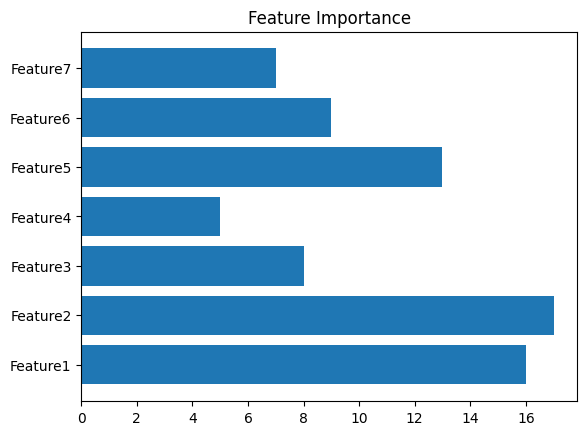

In [73]:
# For Q4

# Use simply counting to get the feature importance: dt_depth10.importance

labelList=['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']

plt.title('Feature Importance')
plt.barh(labelList, dt_depth10.importance.values())
plt.show()

# Questions for Random Rorest

In [74]:
# For Q5-1, validation accuracy should be higher than or equal to 0.88

np.random.seed(0)

rf_estimators10 = RandomForest(n_estimators=10, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='gini', max_depth=None)
rf_estimators10.fit(X_train, y_train)

print("Q6-1 n_estimators=10: ", accuracy_score(y_val, rf_estimators10.predict(X_val)))

Q6-1 n_estimators=10:  0.88625


In [75]:
# For Q5-2, validation accuracy should be higher than or equal to 0.89

np.random.seed(0)

rf_estimators50 = RandomForest(n_estimators=50, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='gini', max_depth=None)
rf_estimators50.fit(X_train, y_train)

print("Q6-1 n_estimators=50: ", accuracy_score(y_val, rf_estimators50.predict(X_val)))

Q6-1 n_estimators=50:  0.89625


In [76]:
# For Q6-1, validation accuracy should be higher than or equal to 0.88

np.random.seed(0)

rf_maxfeature_sqrt = RandomForest(n_estimators=10, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='gini', max_depth=None)
rf_maxfeature_sqrt.fit(X_train, y_train)

print("Q7-1 max_features='sqrt': ", accuracy_score(y_val,  rf_maxfeature_sqrt.predict(X_val)))

Q7-1 max_features='sqrt':  0.88625


In [77]:
# For Q6-2, validation accuracy should be higher than or equal to 0.86

np.random.seed(0)

rf_maxfeature_none = RandomForest(n_estimators=10, max_features=None, boostrap=True, criterion='gini', max_depth=None)
rf_maxfeature_none.fit(X_train, y_train)

print("Q7-1 max_features='All': ", accuracy_score(y_val, rf_maxfeature_none.predict(X_val)))

Q7-1 max_features='All':  0.86625


# Train your own model

In [78]:
def varible_extend( df, expend = ['Feature1','Feature2','Feature3','Feature4','Feature5','Feature6','Feature7'] ) :
    X = df.drop('Target', axis=1)

    for i in range(len(expend)) :
        for j in range(i,len(expend)) :
            name = f'{expend[i]}*{expend[j]}'
            X[name] = X[expend[i]]*X[expend[j]]
            # X[name] = (X[name] - X[name].mean())/X[name].std()

    # for i in range(len(expend)) :        
    #     X[expend[i]] = (X[expend[i]] - X[expend[i]].mean())/X[expend[i]].std() 
    
    return X

In [79]:
df_train = pd.DataFrame(pd.read_csv("./PR_HW3_Train.csv"))
df_val   = pd.DataFrame(pd.read_csv("./PR_HW3_Val.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW3_Test.csv"))

X_train = varible_extend(df_train).to_numpy()
y_train = df_train["Target"].to_numpy()

X_val = varible_extend(df_val).to_numpy()
y_val = df_val["Target"].to_numpy()

X_test = varible_extend(df_test).to_numpy()


In [80]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)

(800, 35)
(800,)
(800, 35)
(800,)
(800, 35)


In [81]:
# Build and train your model
#150 0.901
# tree   140 accuracy :  0.9
# tree   275 accuracy :  0.90125
accuracy = 0
best = 0

np.random.seed(2)
rf_maxfeature_sqrt = RandomForest(n_estimators=275, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='gini', max_depth=None)
rf_maxfeature_sqrt.fit(X_train, y_train)
    


In [82]:
test_pred = rf_maxfeature_sqrt.predict(X_test)

print("test_pred shape: ", test_pred.shape)

test_pred shape:  (800,)


In [83]:
"""
    Updated as of 20:30 on Apr. 22.
    We have modified the baseline score, please check the HW3 slide.
"""
print("Q7-1 max_features='sqrt': ", accuracy_score(y_val,  rf_maxfeature_sqrt.predict(X_val)))

Q7-1 max_features='sqrt':  0.90125


In [84]:
# output csv
df_test = pd.DataFrame(pd.read_csv("./PR_HW3_Test.csv"))
df_test["Target"] = test_pred
df_test.to_csv("311553032_prediction.csv")